## Data Preperation

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#  Load the dataset
file_path = "D:\Coding\Energy-Management_Project\data\data_15min.csv"
df = pd.read_csv(file_path)

In [3]:
print("Initial shape:", df.shape)
print(df.dtypes)
print(df.isnull().sum().head())  # Show top missing values

Initial shape: (153810, 71)
utc_timestamp                          object
cet_cest_timestamp                     object
DE_KN_industrial1_grid_import         float64
DE_KN_industrial1_pv_1                float64
DE_KN_industrial1_pv_2                float64
                                       ...   
DE_KN_residential6_grid_export        float64
DE_KN_residential6_grid_import        float64
DE_KN_residential6_pv                 float64
DE_KN_residential6_washing_machine    float64
Unnamed: 70                            object
Length: 71, dtype: object
utc_timestamp                        0
cet_cest_timestamp                   0
DE_KN_industrial1_grid_import    88080
DE_KN_industrial1_pv_1           84659
DE_KN_industrial1_pv_2           84659
dtype: int64


In [4]:
# Convert timestamp to datetime and set index
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], utc=True, errors='coerce')
df.set_index('utc_timestamp', inplace=True)

In [5]:
df.columns

Index(['cet_cest_timestamp', 'DE_KN_industrial1_grid_import',
       'DE_KN_industrial1_pv_1', 'DE_KN_industrial1_pv_2',
       'DE_KN_industrial2_grid_import', 'DE_KN_industrial2_pv',
       'DE_KN_industrial2_storage_charge',
       'DE_KN_industrial2_storage_decharge', 'DE_KN_industrial3_area_offices',
       'DE_KN_industrial3_area_room_1', 'DE_KN_industrial3_area_room_2',
       'DE_KN_industrial3_area_room_3', 'DE_KN_industrial3_area_room_4',
       'DE_KN_industrial3_compressor', 'DE_KN_industrial3_cooling_aggregate',
       'DE_KN_industrial3_cooling_pumps', 'DE_KN_industrial3_dishwasher',
       'DE_KN_industrial3_ev', 'DE_KN_industrial3_grid_import',
       'DE_KN_industrial3_machine_1', 'DE_KN_industrial3_machine_2',
       'DE_KN_industrial3_machine_3', 'DE_KN_industrial3_machine_4',
       'DE_KN_industrial3_machine_5', 'DE_KN_industrial3_pv_facade',
       'DE_KN_industrial3_pv_roof', 'DE_KN_industrial3_refrigerator',
       'DE_KN_industrial3_ventilation', 'DE_KN_public1

In [6]:
# Filter only the required column

target_col = 'DE_KN_residential1_heat_pump'
df = df[[target_col]].copy()

In [7]:
# Rename target column
df.rename(columns={target_col: 'r1_hp'}, inplace=True)

In [8]:
# Drop missing value
df.dropna(inplace=True)

In [9]:
# check
print("Data after cleaning:")
print(df.head())
print("Data range:", df.index.min(), "to", df.index.max())
print("Data frequency check (first 5 diffs):\n", df.index.to_series().diff().head())

Data after cleaning:
                           r1_hp
utc_timestamp                   
2015-05-21 15:30:00+00:00  0.000
2015-05-21 15:45:00+00:00  0.010
2015-05-21 16:00:00+00:00  0.010
2015-05-21 16:15:00+00:00  0.010
2015-05-21 16:30:00+00:00  0.308
Data range: 2015-05-21 15:30:00+00:00 to 2017-03-12 23:00:00+00:00
Data frequency check (first 5 diffs):
 utc_timestamp
2015-05-21 15:30:00+00:00               NaT
2015-05-21 15:45:00+00:00   0 days 00:15:00
2015-05-21 16:00:00+00:00   0 days 00:15:00
2015-05-21 16:15:00+00:00   0 days 00:15:00
2015-05-21 16:30:00+00:00   0 days 00:15:00
Name: utc_timestamp, dtype: timedelta64[ns]


### Convert cumulative data into actual per-interval usage

In [10]:
# Convert cumulative to actual usage
df['r1_hp'] = df['r1_hp'].diff()

# Drop the first row which becomes NaN after diff
df.dropna(inplace=True)

In [11]:
# Optional sanity check for negative values
print("Negative values count:", (df['r1_hp'] < 0).sum())


df = df[df['r1_hp'] >= 0]  # or df['r1_hp'] = df['r1_hp'].clip(lower=0)

Negative values count: 0


## Data Viz

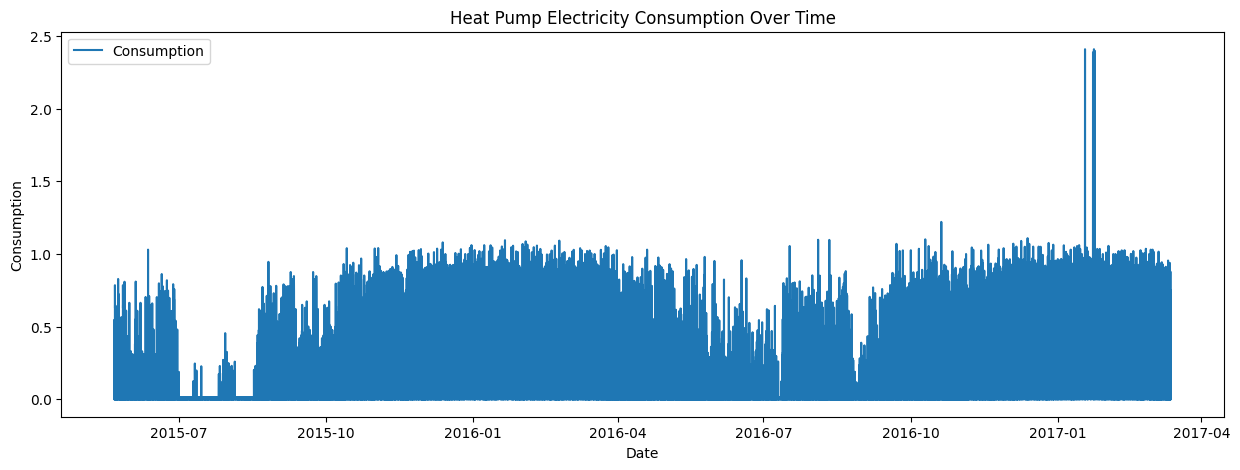

In [12]:
#Plot the time series consumption
plt.figure(figsize=(15,5))
plt.plot(df.index, df['r1_hp'], label='Consumption')
plt.title('Heat Pump Electricity Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.legend()
plt.show()

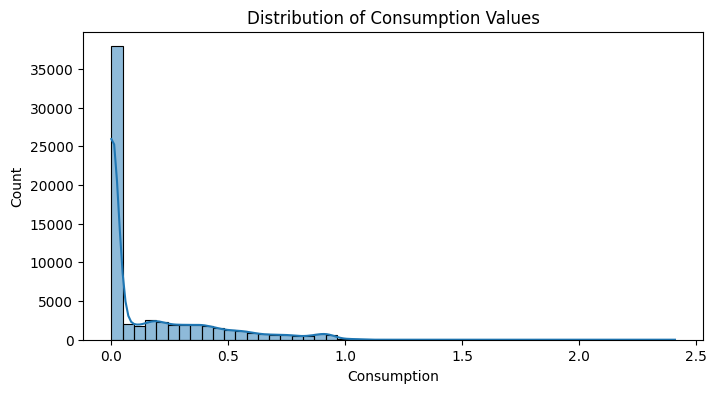

In [13]:
# Distribution plot of consumption
plt.figure(figsize=(8,4))
sns.histplot(df['r1_hp'], bins=50, kde=True)
plt.title('Distribution of Consumption Values')
plt.xlabel('Consumption')
plt.show()

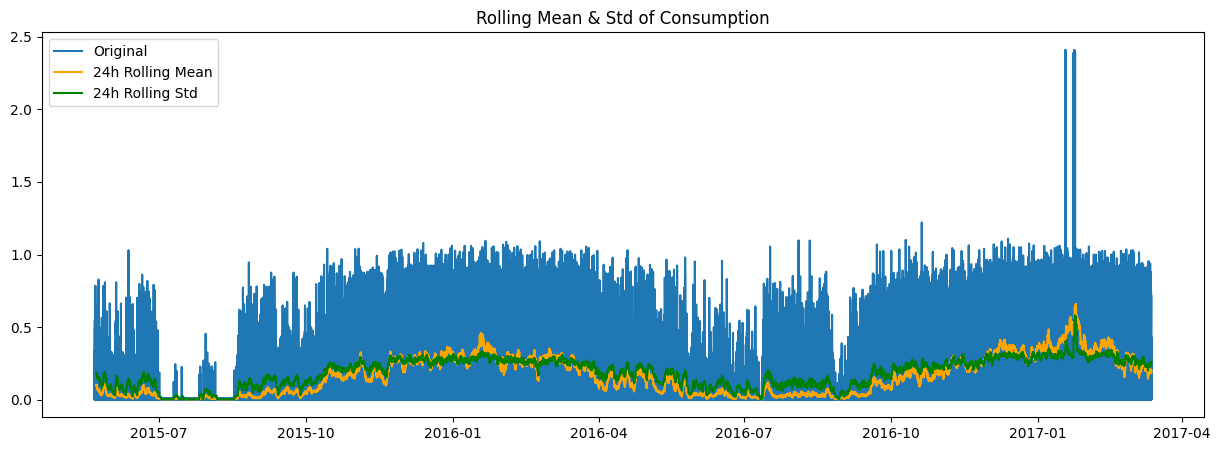

In [ ]:
# Rolling mean and rolling std to check trend and seasonality

rolling_window = 96  # 96 * 15min = 24 hours
plt.figure(figsize=(15,5))
plt.plot(df['r1_hp'], label='Original')
plt.plot(df['r1_hp'].rolling(window=rolling_window).mean(), label='24h Rolling Mean', color='orange')
plt.plot(df['r1_hp'].rolling(window=rolling_window).std(), label='24h Rolling Std', color='green') 
plt.title('Rolling Mean & Std of Consumption')
plt.legend()
plt.show()

## Time-Series Viz

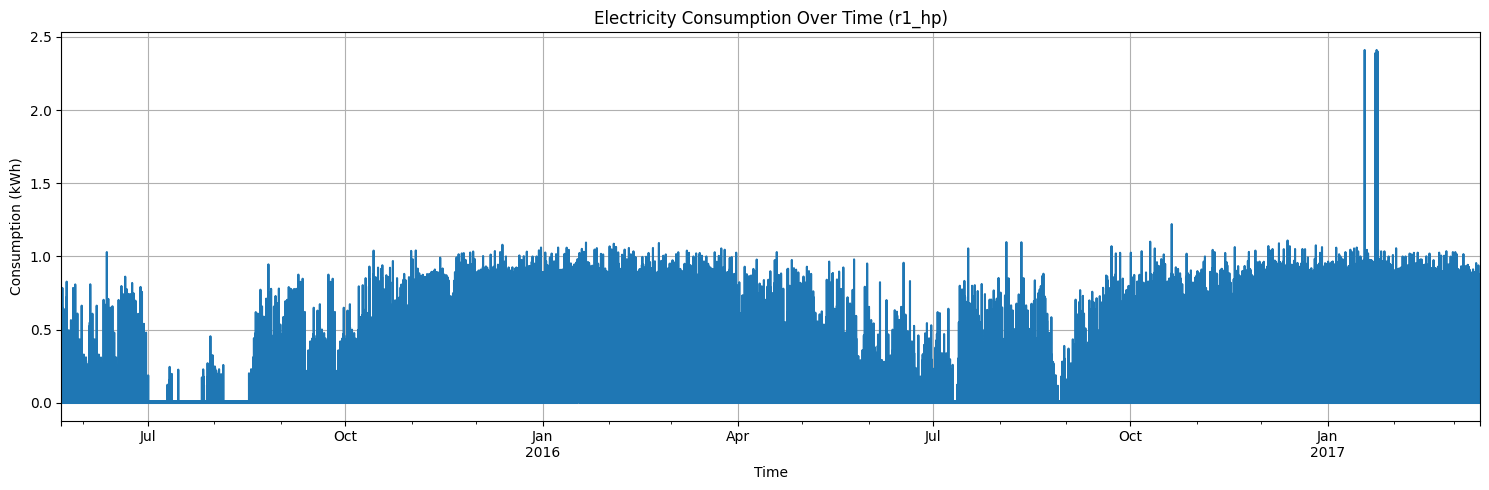

In [15]:
plt.figure(figsize=(15,5))
df['r1_hp'].plot()
plt.title("Electricity Consumption Over Time (r1_hp)")
plt.ylabel("Consumption (kWh)")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()

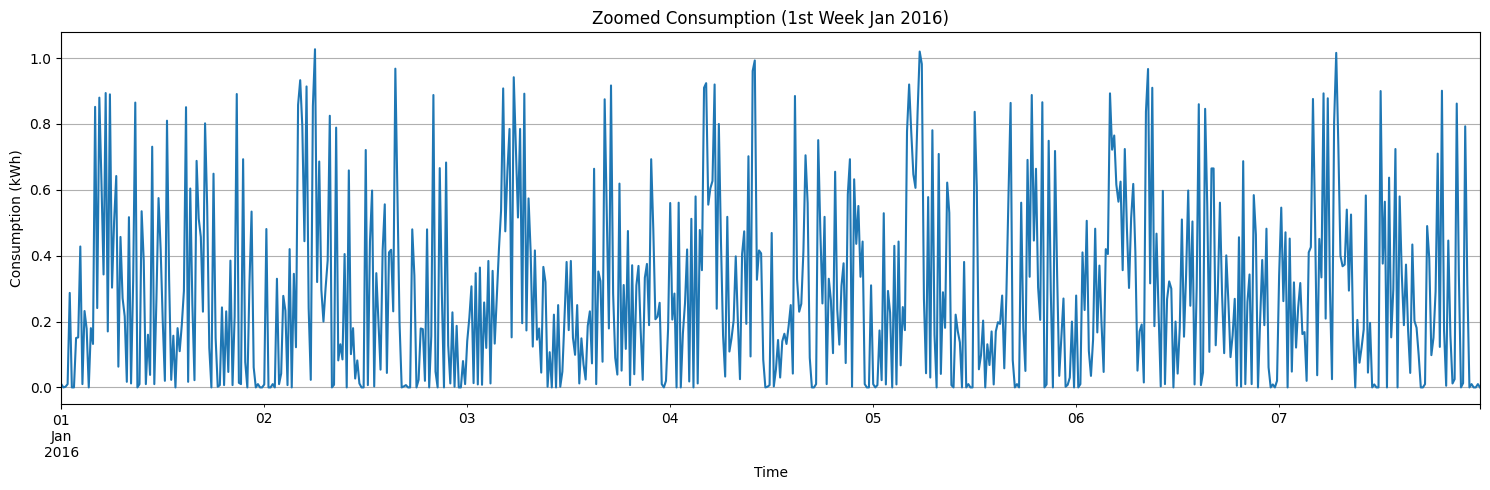

In [16]:
df_zoom = df['2016-01-01':'2016-01-07']
plt.figure(figsize=(15,5))
df_zoom['r1_hp'].plot()
plt.title("Zoomed Consumption (1st Week Jan 2016)")
plt.ylabel("Consumption (kWh)")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()


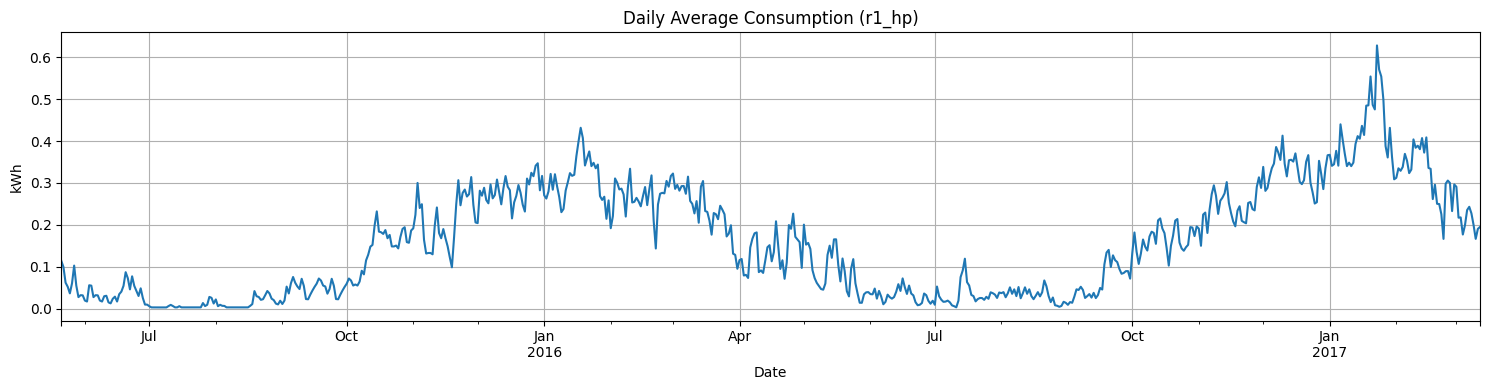

In [17]:
# daily avg consumption(daily resampling)

df_daily = df['r1_hp'].resample('D').mean()

plt.figure(figsize=(15,4))
df_daily.plot()
plt.title("Daily Average Consumption (r1_hp)")
plt.ylabel("kWh")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


## Adding ON/OFF Column

In [25]:
# Create ON/OFF column: 1 if heat pump was ON, 0 if OFF
# It works fine, but:It might be too sensitive to noise (e.g., 0.001 kWh is not meaningful). Might misclassify short spikes or drops in cumulative readings.
# so chose to consider 0.01 as threshold instead of 0

threshold = 0.05
df['r1_hp_onoff'] = (df['r1_hp'] > threshold).astype(int)

In [26]:
# Check result
print(df[['r1_hp', 'r1_hp_onoff']].head(20))
print("\nValue counts:")
print(df['r1_hp_onoff'].value_counts())

                           r1_hp  r1_hp_onoff
utc_timestamp                                
2015-05-21 15:45:00+00:00  0.010            0
2015-05-21 16:00:00+00:00  0.000            0
2015-05-21 16:15:00+00:00  0.000            0
2015-05-21 16:30:00+00:00  0.298            1
2015-05-21 16:45:00+00:00  0.202            1
2015-05-21 17:00:00+00:00  0.010            0
2015-05-21 17:15:00+00:00  0.000            0
2015-05-21 17:30:00+00:00  0.339            1
2015-05-21 17:45:00+00:00  0.000            0
2015-05-21 18:00:00+00:00  0.010            0
2015-05-21 18:15:00+00:00  0.301            1
2015-05-21 18:30:00+00:00  0.257            1
2015-05-21 18:45:00+00:00  0.022            0
2015-05-21 19:00:00+00:00  0.084            1
2015-05-21 19:15:00+00:00  0.547            1
2015-05-21 19:30:00+00:00  0.000            0
2015-05-21 19:45:00+00:00  0.053            1
2015-05-21 20:00:00+00:00  0.297            1
2015-05-21 20:15:00+00:00  0.158            1
2015-05-21 20:30:00+00:00  0.043  

In [27]:
# Count total ON and OFF states
on_off_counts = df['r1_hp_onoff'].value_counts().rename(index={0: 'OFF', 1: 'ON'})

print("Heat Pump ON/OFF Summary:")
print(on_off_counts)


Heat Pump ON/OFF Summary:
r1_hp_onoff
OFF    37961
ON     25525
Name: count, dtype: int64


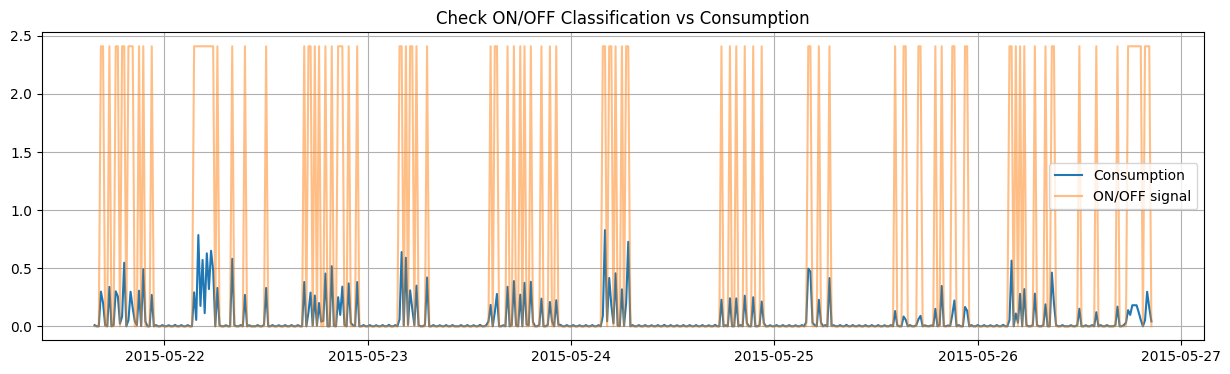

In [28]:
# ON/OFF Plot

plt.figure(figsize=(15,4))
plt.plot(df.index[:500], df['r1_hp'][:500], label="Consumption")
plt.plot(df.index[:500], df['r1_hp_onoff'][:500]*df['r1_hp'].max(), label="ON/OFF signal", alpha=0.5)
plt.legend()
plt.title("Check ON/OFF Classification vs Consumption")
plt.grid(True)
plt.show()


In [31]:
# Check the distribution of r1_hp when ON

print(df[df['r1_hp_onoff'] == 1]['r1_hp'].describe())
print("\nVery low ON readings (< 0.05 kWh):", (df['r1_hp'] < threshold).sum())

count    25525.000000
mean         0.393097
std          0.246446
min          0.050000
25%          0.195000
50%          0.346000
75%          0.541000
max          2.410000
Name: r1_hp, dtype: float64

Very low ON readings (< 0.05 kWh): 37961


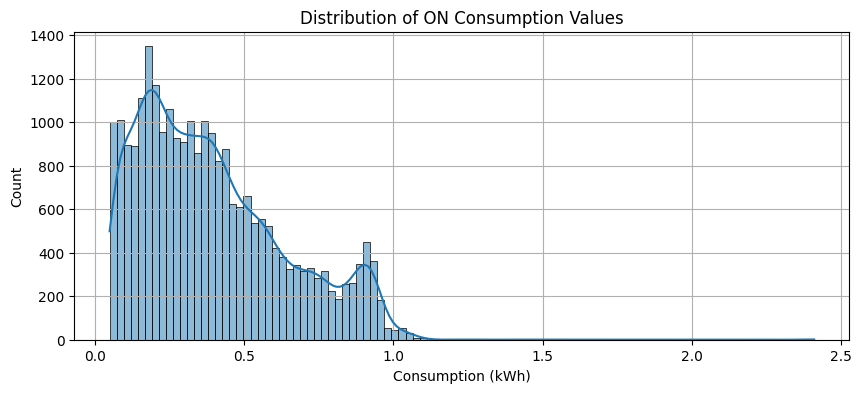

In [30]:
# Plot histogram of ON consumption

import seaborn as sns
plt.figure(figsize=(10,4))
sns.histplot(df[df['r1_hp_onoff'] == 1]['r1_hp'], bins=100, kde=True)
plt.title("Distribution of ON Consumption Values")
plt.xlabel("Consumption (kWh)")
plt.grid(True)
plt.show()

## Feature Creation(Date time feautures)

In [33]:
# time-based features from your datetime index to help the model learn patterns related to when the appliance tends to be ON or OFF.

df_feat = df.copy()
df_feat['hour'] = df_feat.index.hour
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['quarter'] = df_feat.index.quarter
df_feat['month'] = df_feat.index.month
df_feat['year'] = df_feat.index.year
df_feat['dayofyear'] = df_feat.index.dayofyear
df_feat['dayofmonth'] = df_feat.index.day
df_feat['weekofyear'] = df_feat.index.isocalendar().week.astype(int)


In [34]:
# Check the new dataframe structure and sample values
print(df_feat.head())

                           r1_hp  r1_hp_onoff  hour  dayofweek  quarter  \
utc_timestamp                                                             
2015-05-21 15:45:00+00:00  0.010            0    15          3        2   
2015-05-21 16:00:00+00:00  0.000            0    16          3        2   
2015-05-21 16:15:00+00:00  0.000            0    16          3        2   
2015-05-21 16:30:00+00:00  0.298            1    16          3        2   
2015-05-21 16:45:00+00:00  0.202            1    16          3        2   

                           month  year  dayofyear  dayofmonth  weekofyear  
utc_timestamp                                                              
2015-05-21 15:45:00+00:00      5  2015        141          21          21  
2015-05-21 16:00:00+00:00      5  2015        141          21          21  
2015-05-21 16:15:00+00:00      5  2015        141          21          21  
2015-05-21 16:30:00+00:00      5  2015        141          21          21  
2015-05-21 16:45:0

## Visualize Feature-Target Relationship (for ON data only)

In [35]:
# Filter ON rows
df_on = df[df['r1_hp_onoff'] == 1].copy()

In [26]:
# Create time features for df_on
df_on['hour'] = df_on.index.hour
df_on['dayofweek'] = df_on.index.dayofweek

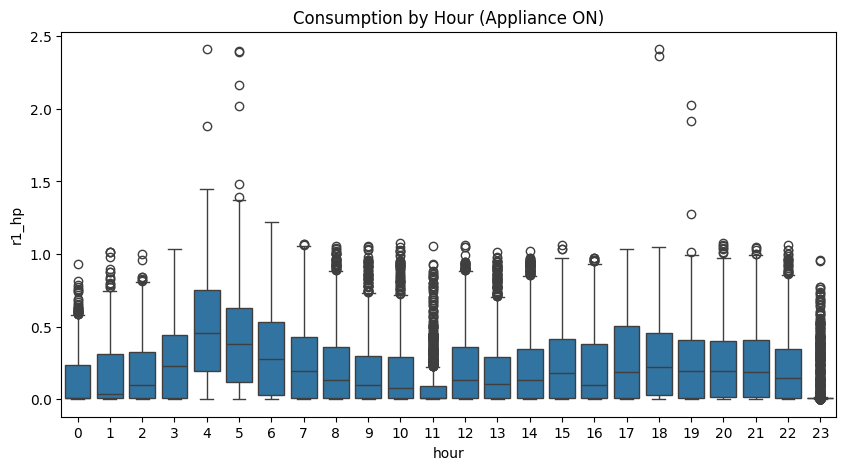

In [27]:

plt.figure(figsize=(10,5))
sns.boxplot(x='hour', y='r1_hp', data=df_on)
plt.title('Consumption by Hour (Appliance ON)')
plt.show()

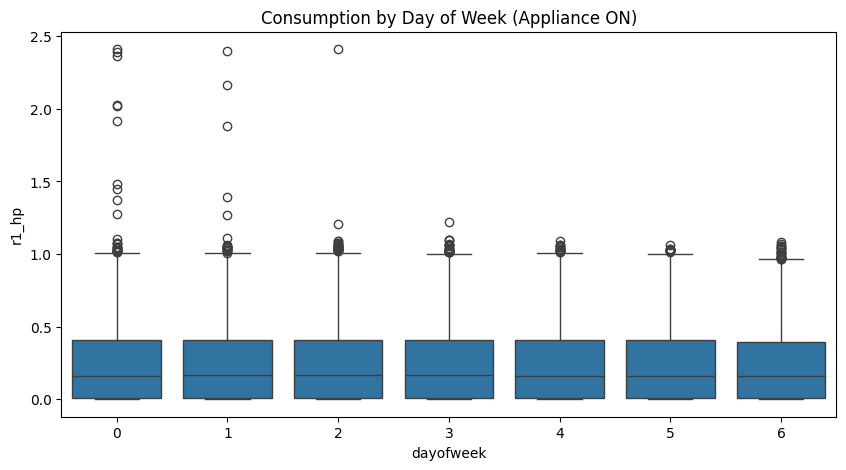

In [28]:
plt.figure(figsize=(10,5))
sns.boxplot(x='dayofweek', y='r1_hp', data=df_on)
plt.title('Consumption by Day of Week (Appliance ON)')
plt.show()

In [ ]:
# Group-wise statistics (mean, median, std) of consumption by hour


df_on.groupby('hour')['r1_hp'].agg(['mean', 'median', 'std', 'count'])


,mean,median,std,count
hour,,,,
0,0.132235,0.0100,0.178640,1475
1,0.163049,0.0400,0.199061,1574
2,0.178713,0.0965,0.198364,1646
3,0.277706,0.2300,0.262897,1934
4,0.468037,0.4570,0.317723,2325
5,0.405635,0.3780,0.315677,2165
6,0.330561,0.2790,0.298186,1963
7,0.264991,0.1980,0.265717,1793
8,0.217871,0.1310,0.248100,1727


In [ ]:
# Summary statistics of consumption by day of week

df_on.groupby('dayofweek')['r1_hp'].describe()


,count,mean,std,min,25%,50%,75%,max
dayofweek,,,,,,,,
0,5865.0,0.246953,0.275624,0.001,0.01,0.1600,0.409,2.410
1,5792.0,0.251801,0.273879,0.002,0.01,0.1700,0.410,2.400
2,5852.0,0.250447,0.270810,0.002,0.01,0.1690,0.411,2.410
3,5944.0,0.248867,0.265960,0.001,0.01,0.1710,0.409,1.221
4,5901.0,0.248343,0.268774,0.002,0.01,0.1640,0.410,1.090
5,5888.0,0.243320,0.264612,0.002,0.01,0.1625,0.410,1.061
6,6094.0,0.240186,0.258048,0.002,0.01,0.1600,0.392,1.080


In [31]:
# Count how many times the heat pump is ON in each hour (ON frequency)

df['r1_hp_onoff'].groupby(df.index.hour).sum()

utc_timestamp
0     1475
1     1574
2     1646
3     1934
4     2325
5     2165
6     1963
7     1793
8     1727
9     1637
10    1379
11    1171
12    1627
13    1636
14    1716
15    1656
16    1497
17    1626
18    1963
19    1944
20    1922
21    1950
22    1821
23    1189
Name: r1_hp_onoff, dtype: int64

## Train Test Split (time order series)

In [32]:
# Define the exact time range for training and testing

train_start = pd.Timestamp("2016-10-01 00:00:00+00:00")
train_end = pd.Timestamp("2016-10-31 23:45:00+00:00")
test_start = pd.Timestamp("2016-11-01 00:00:00+00:00")
test_end = pd.Timestamp("2016-11-07 23:45:00+00:00")

In [33]:
# Create boolean masks that are True when the row timestamp falls within train/test periods

train_mask = (df_feat.index >= train_start) & (df_feat.index <= train_end)
test_mask = (df_feat.index >= test_start) & (df_feat.index <= test_end)

In [34]:
# Select features and target columns

feature_cols = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
target_col = 'r1_hp_onoff'

In [35]:
# Split the feature matrix and target vector for train and test

X_train = df_feat.loc[train_mask, feature_cols]
y_train = df_feat.loc[train_mask, target_col]

In [36]:
X_test = df_feat.loc[test_mask, feature_cols]
y_test = df_feat.loc[test_mask, target_col]


In [37]:
# Print shapes and summary counts to verify

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train ON count: {y_train.sum()}, Test ON count: {y_test.sum()}")

Train shape: (2976, 8), Test shape: (672, 8)
Train ON count: 2021, Test ON count: 496


## Train-Test Split for ON/OFF Model

In [38]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [39]:
# Initialize and train the XGBoost Classifier
model_onoff = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train model
model_onoff.fit(X_train, y_train)


d:\Coding\Energy_Management\em\lib\site-packages\xgboost\training.py:183: UserWarning: [15:58:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [40]:
# predict ON/OFF TEST

y_pred_onoff = model_onoff.predict(X_test)

In [ ]:
# evaluate model performance

print("Accuracy:", accuracy_score(y_test, y_pred_onoff))
print("\nClassification Report:\n", classification_report(y_test, y_pred_onoff))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_onoff))


Accuracy: 0.6875

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.28      0.32       176
           1       0.76      0.83      0.80       496

    accuracy                           0.69       672
   macro avg       0.57      0.56      0.56       672
weighted avg       0.66      0.69      0.67       672


Confusion Matrix:
 [[ 49 127]
 [ 83 413]]


####

Accuracy 68.75% means about 7 out of 10 predictions are correct overall.

Class 1 (ON) performance is good:

Precision 76% → When model predicts ON, it's right 76% of the time.

Recall 83% → It correctly identifies 83% of the actual ON cases.

F1-score 80% → Good balance between precision and recall.

Class 0 (OFF) performance is weak:

Precision 37% → When model predicts OFF, it’s right only 37% of the time.

Recall 28% → It only identifies 28% of actual OFF cases.

F1-score 32% → Poor performance detecting OFF.

Confusion matrix shows lots of false positives (OFF predicted as ON: 127) and false negatives (ON predicted as OFF: 83).

## Regression model (predict consumption when ON)

In [42]:
# Filter data where heat pump is ON (consumption > 0)
df_reg = df[df['r1_hp_onoff'] == 1].copy()

In [43]:
# Create time-based features again for this subset
df_reg['hour'] = df_reg.index.hour
df_reg['dayofweek'] = df_reg.index.dayofweek
df_reg['quarter'] = df_reg.index.quarter
df_reg['month'] = df_reg.index.month
df_reg['year'] = df_reg.index.year
df_reg['dayofyear'] = df_reg.index.dayofyear
df_reg['dayofmonth'] = df_reg.index.day
df_reg['weekofyear'] = df_reg.index.isocalendar().week.astype(int)

In [44]:
# Define features and target for regression
feature_cols_reg = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
target_col_reg = 'r1_hp'  # Actual consumption values


In [45]:
# Define train/test date ranges (keep consistent with ON/OFF model)
train_mask_reg = (df_reg.index >= train_start) & (df_reg.index <= train_end)
test_mask_reg = (df_reg.index >= test_start) & (df_reg.index <= test_end)

X_train_reg = df_reg.loc[train_mask_reg, feature_cols_reg]
y_train_reg = df_reg.loc[train_mask_reg, target_col_reg]

X_test_reg = df_reg.loc[test_mask_reg, feature_cols_reg]
y_test_reg = df_reg.loc[test_mask_reg, target_col_reg]


In [46]:
# Check shapes

print(f"Regression train shape: {X_train_reg.shape}, test shape: {X_test_reg.shape}")
print(f"Regression train target mean: {y_train_reg.mean():.4f}, test target mean: {y_test_reg.mean():.4f}")

Regression train shape: (2021, 8), test shape: (496, 8)
Regression train target mean: 0.2433, test target mean: 0.2874


## Train and Evaluate the Regression Model

In [52]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [48]:
# Initialize the XGBoost Regressor

reg_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)

In [49]:
# Train the model

reg_model.fit(X_train_reg, y_train_reg)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [50]:
# Predict on test data

y_pred_reg = reg_model.predict(X_test_reg)

In [53]:
# Evaluate

mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)  # manually compute RMSE
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

In [54]:
print(f"Regression Model Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Regression Model Evaluation:
RMSE: 0.2326
MAE: 0.1895
R² Score: 0.0658


## Predicting

In [55]:
# Predict on test set
y_test_pred = reg_model.predict(X_test)

In [58]:
# Create DataFrame to hold actual and predicted values with timestamps as index
df_test_compare = pd.DataFrame({
    'Actual Consumption': y_test_reg,
    'Predicted Consumption': y_test_pred
}, index=X_test.index)

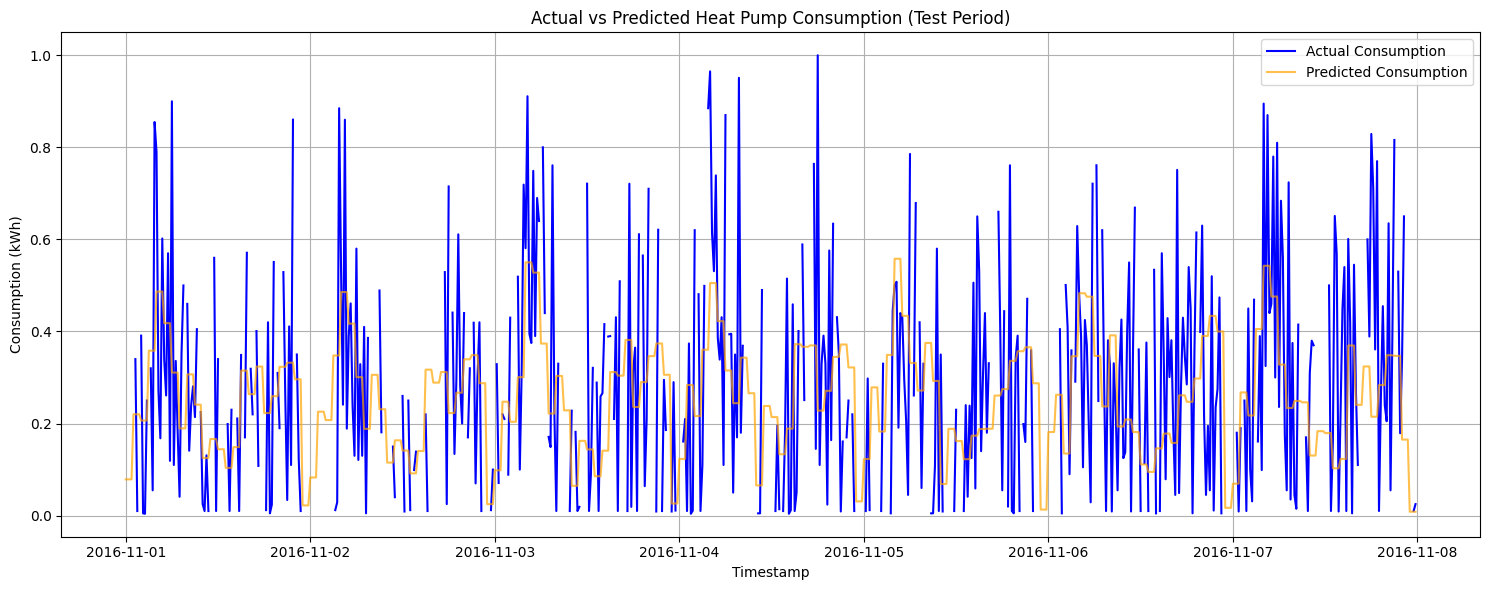

In [59]:
# Plot actual vs predicted values
plt.figure(figsize=(15,6))
plt.plot(df_test_compare.index, df_test_compare['Actual Consumption'], label='Actual Consumption', color='blue')
plt.plot(df_test_compare.index, df_test_compare['Predicted Consumption'], label='Predicted Consumption', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Heat Pump Consumption (Test Period)')
plt.xlabel('Timestamp')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Afterwards prediction

In [67]:
future_start = pd.Timestamp("2016-11-08 00:00:00+00:00")
future_end = pd.Timestamp("2016-11-14 23:45:00+00:00")

df_future = df.copy()
df_future = df_future.loc[future_start:future_end].copy()


In [68]:
# Feature generation
df_future['hour'] = df_future.index.hour
df_future['dayofweek'] = df_future.index.dayofweek
df_future['quarter'] = df_future.index.quarter
df_future['month'] = df_future.index.month
df_future['year'] = df_future.index.year
df_future['dayofyear'] = df_future.index.dayofyear
df_future['dayofmonth'] = df_future.index.day
df_future['weekofyear'] = df_future.index.isocalendar().week.astype(int)

In [70]:
model_reg = XGBRegressor(random_state=42)
model_reg.fit(X_train_reg, y_train_reg)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [71]:
X_future = df_future[feature_cols]
future_preds = model_reg.predict(X_future)
df_future['Predicted_r1_hp'] = future_preds


In [72]:
# 10. View Future Predictions
# ----------------------------
print("\nSample future predictions:")
print(df_future[['r1_hp', 'Predicted_r1_hp']].head(10))


Sample future predictions:
                           r1_hp  Predicted_r1_hp
utc_timestamp                                    
2016-11-08 00:00:00+00:00  0.366         0.055683
2016-11-08 00:15:00+00:00  0.000         0.055683
2016-11-08 00:30:00+00:00  0.200         0.055683
2016-11-08 00:45:00+00:00  0.159         0.055683
2016-11-08 01:00:00+00:00  0.000         0.245253
2016-11-08 01:15:00+00:00  0.420         0.245253
2016-11-08 01:30:00+00:00  0.000         0.245253
2016-11-08 01:45:00+00:00  0.391         0.245253
2016-11-08 02:00:00+00:00  0.009         0.200390
2016-11-08 02:15:00+00:00  0.301         0.200390


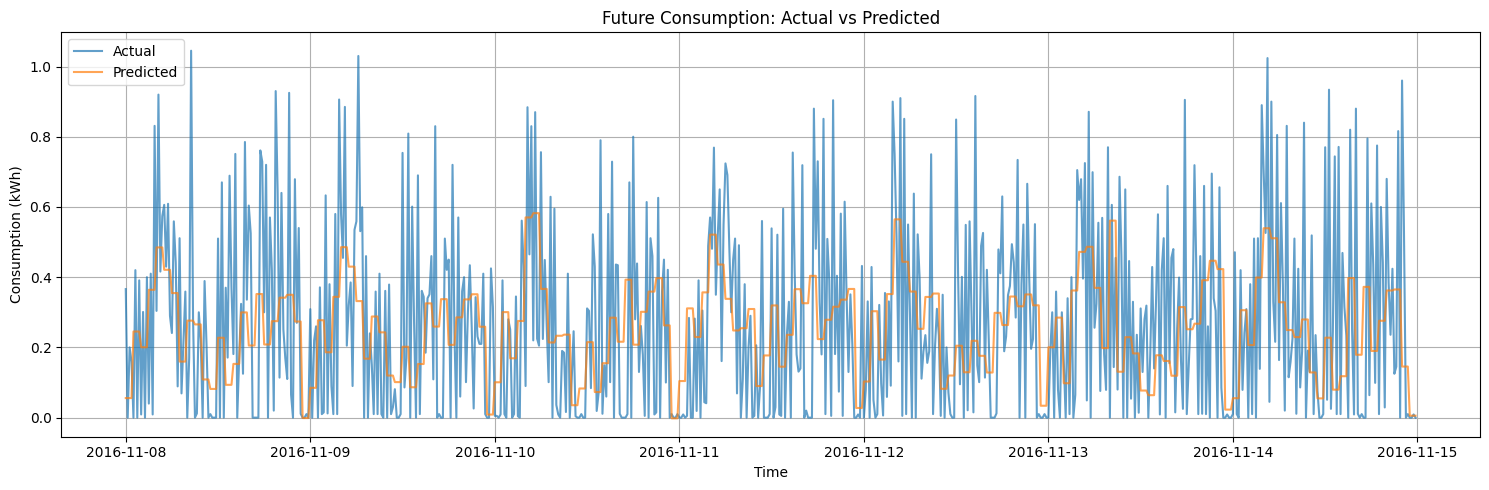

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(df_future.index, df_future['r1_hp'], label='Actual', alpha=0.7)
plt.plot(df_future.index, df_future['Predicted_r1_hp'], label='Predicted', alpha=0.7)
plt.title("Future Consumption: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Consumption (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [74]:
df_future['Error'] = df_future['r1_hp'] - df_future['Predicted_r1_hp']
print(df_future['Error'].describe())


count    672.000000
mean       0.014406
std        0.263385
min       -0.561088
25%       -0.177083
50%       -0.032051
75%        0.194046
max        0.814507
Name: Error, dtype: float64


In [75]:
within_margin = (df_future['Error'].abs() <= 0.1).sum()
total_points = len(df_future)
print(f"Predictions within ±0.1 kWh: {within_margin} out of {total_points} ({(within_margin / total_points * 100):.2f}%)")


Predictions within ±0.1 kWh: 184 out of 672 (27.38%)


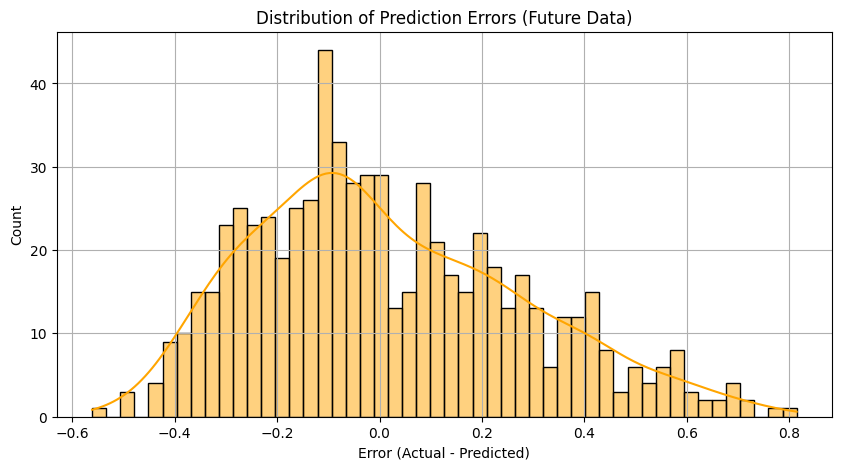

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(df_future['Error'], bins=50, kde=True, color='orange')
plt.title("Distribution of Prediction Errors (Future Data)")
plt.xlabel("Error (Actual - Predicted)")
plt.grid(True)
plt.show()
